In [1]:
import random
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

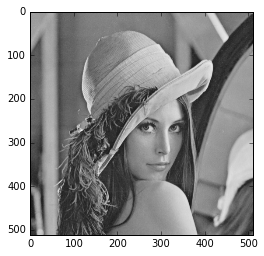

In [2]:
kernel = [[-2, -1], [-2, 0], [-2, 1],
          [-1, -2], [-1, -1], [-1, 0], [-1, 1], [-1, 2], 
          [0, -2], [0, -1], [0, 0], [0, 1], [0, 2],
          [1, -2], [1, -1], [1, 0], [1, 1], [1, 2],
          [2, -1], [2, 0], [2, 1]]
SNR_dict = {}
img = Image.open('lena.bmp')
plt.figure(1)
fig = plt.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=255)

In [3]:
def dilation(img, kernel):
    height, width = img.size
    new_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(height):
        for j in range(width):
            if img[i][j] > 0:
                maximum = 0
                for ele in kernel:
                    p, q = ele
                    if (i + p) >= 0 and (i + p) <= (width - 1) and \
                       (j + q) >= 0 and (j + q) <= (height - 1):
                        if img[i + p][j + q] > maximum:
                            maximum = img[i + p][j + q]
                for ele in kernel:
                    p, q = ele
                    if (i + p) >= 0 and (i + p) <= (width - 1) and \
                       (j + q) >= 0 and (j + q) <= (height - 1):
                        new_img[i + p][j + q] = maximum
    return new_img.astype('uint8') 

def erosion(img, kernel):
    height, width = img.size
    new_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(height):
        for j in range(width):
            if img[i][j] > 0:
                flag = True
                minimun = np.inf
                for ele in kernel:
                    p, q = ele
                    if (i + p) >= 0 and (i + p) <= (height - 1) and \
                       (j + q) >= 0 and (j + q) <= (width - 1):
                        if img[i + p][j + q] == 0:
                            flag = False
                            break
                        if img[i + p][j + q] < minimun:
                            minimun = img[i + p][j + q]
                flag = True
                for ele in kernel:
                    p, q = ele
                    if (i + p) >= 0 and (i + p) <= (height - 1) and \
                       (j + q) >= 0 and (j + q) <= (width - 1):
                        if img[i + p][j + q] == 0:
                            flag = False
                            break
                    if (i + p) >= 0 and (i + p) <= (height- 1) and \
                       (j + q) >= 0 and (j + q) <= (width - 1) and \
                       flag:
                        new_img[i + p][j + q] = minimun
    return new_img.astype('uint8')

def closing(img, kernel):
    dilation_img = dilation(img, kernel)
    closing_img = erosion(Image.fromarray(dilation_img), kernel)
    return closing_img.astype('uint8')

def opening(img, kernel):
    erosion_img = erosion(img, kernel)
    opening_img = dilation(Image.fromarray(erosion_img), kernel)
    return opening_img.astype('uint8')

def closing_then_opening(img, kernel):
    return opening(Image.fromarray(closing(img, kernel)), kernel)

def opening_then_closing(img, kernel):
    return closing(Image.fromarray(opening(img, kernel)), kernel)

def gaussian_noice(img, amplitude):
    height, width = img.size
    guassian_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(width):
        for j in range(height):
            noise = img[i][j] + amplitude * random.gauss(0, 1)
            if noise > 255:
                noise = 255
            guassian_img[i, j] = noise
    return guassian_img.astype('uint8') 

def salt_and_pepper(img, threshold):
    height, width = img.size
    salt_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(width):
        for j in range(height):
            salt_img[i][j] = img[i][j]
            random_value = random.uniform(0, 1)
            if random_value < threshold:
                salt_img[i][j] = 0
            elif random_value > 1 - threshold:
                salt_img[i][j] = 255
    return salt_img.astype('uint8') 

def SNR(img, noise_img):
    height, width = img.size
    img = np.asarray(img, dtype=np.float32)
    noise_img = np.asarray(noise_img, dtype=np.float32)
    n = width * height
    M = .0
    for i in range(width):
        for j in range(height):
            M += img[i][j]
    M /= n
    M_n = .0
    for i in range(width):
        for j in range(height):
            M_n += (img[i][j] - noise_img[i][j])
    M_n /= n
    vs = .0
    for i in range(width):
        for j in range(height):
            vs += (img[i][j] - M)**2
    vs /= n
    vn = .0
    for i in range(width):
        for j in range(height):
            vn += (img[i][j] - noise_img[i][j] - M_n)**2
    vn /= n
    return 20 * np.log10((vs / vn)**0.5)

def box_filter(img, box_size):
    height, width = img.size
    new_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(width):
        for j in range(height):
            box_lt = []
            start = (i - (box_size[0] / 2), j - (box_size[1] / 2))
            for c in range(box_size[0]):
                for r in range(box_size[1]):
                    x = int(start[0]) + c
                    y = int(start[1]) + r
                    if x >= 0 and x < width and y >= 0 and y < height:
                        box_lt.append(img[x][y])
            new_img[i][j] = np.mean(box_lt)
    return new_img.astype('uint8')

def median_filter(img, box_size):
    height, width = img.size
    new_img = np.empty(shape=(height, width))
    img = np.asarray(img)
    for i in range(width):
        for j in range(height):
            box_lt = []
            start = (i - (box_size[0] / 2), j - (box_size[1] / 2))
            for c in range(box_size[0]):
                for r in range(box_size[1]):
                    x = int(start[0]) + c
                    y = int(start[1]) + r
                    if x >= 0 and x < width and y >= 0 and y < height:
                        box_lt.append(img[x][y])
            new_img[i][j] = np.median(box_lt)
    return new_img.astype('uint8')

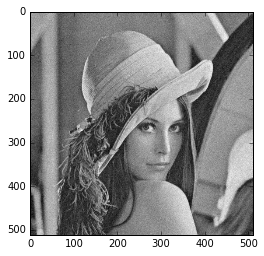

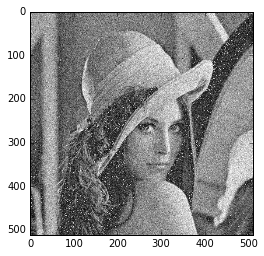

In [4]:
plt.figure(2)
guassian_10 = Image.fromarray(gaussian_noice(img, 10), 'L')
guassian_10.save('guassian_10.bmp')
fig = plt.imshow(np.asarray(guassian_10), cmap='gray', vmin=0, vmax=255) #amplitude 10
SNR_dict['guassian_10'] = SNR(img, guassian_10)
plt.figure(3)
guassian_30 = Image.fromarray(gaussian_noice(img, 30), 'L')
guassian_30.save('guassian_30.bmp')
fig = plt.imshow(np.asarray(guassian_30), cmap='gray', vmin=0, vmax=255) #amplitude 30
SNR_dict['guassian_30'] = SNR(img, guassian_30)

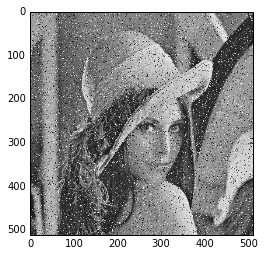

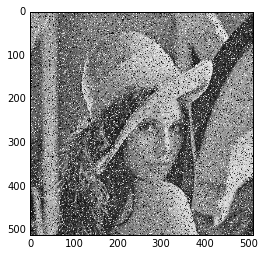

In [5]:
plt.figure(4)
salt_005 = Image.fromarray(salt_and_pepper(img, 0.05), 'L')
salt_005.save('salt_005.bmp')
fig = plt.imshow(np.asarray(salt_005), cmap='gray', vmin=0, vmax=255) #threshold 0.05
SNR_dict['salt_005'] = SNR(img, salt_005)
plt.figure(5)
salt_01 = Image.fromarray(salt_and_pepper(img, 0.1), 'L')
salt_01.save('salt_01.bmp')
fig = plt.imshow(np.asarray(salt_01), cmap='gray', vmin=0, vmax=255) #threshold 0.1
SNR_dict['salt_01'] = SNR(img, salt_01)

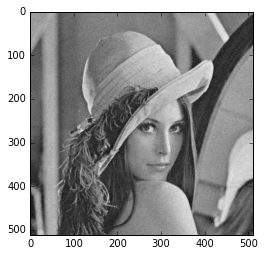

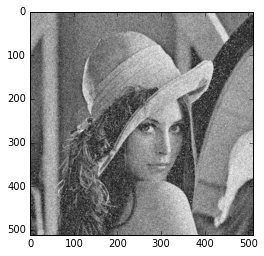

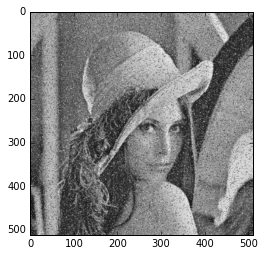

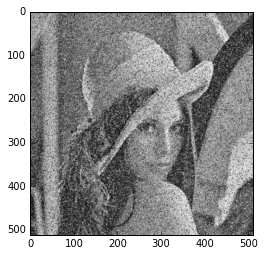

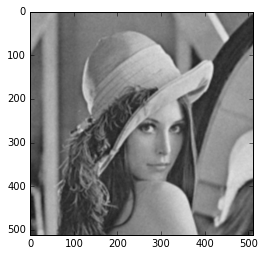

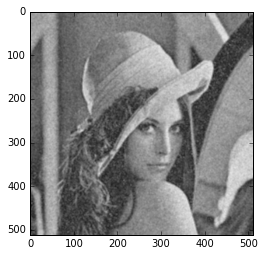

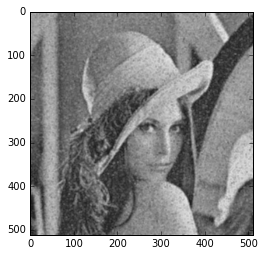

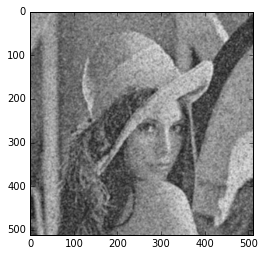

In [6]:
plt.figure(6)
box3x3_gaussian_10 = Image.fromarray(box_filter(guassian_10, (3, 3)), 'L')
box3x3_gaussian_10.save('box3x3_gaussian_10.bmp')
fig = plt.imshow(np.asarray(box3x3_gaussian_10), cmap='gray', vmin=0, vmax=255) #box3x3_gaussian_10
SNR_dict['box3x3_gaussian_10'] = SNR(img, box3x3_gaussian_10)
plt.figure(7)
box3x3_gaussian_30 = Image.fromarray(box_filter(guassian_30, (3, 3)), 'L')
box3x3_gaussian_30.save('box3x3_gaussian_30.bmp')
fig = plt.imshow(np.asarray(box3x3_gaussian_30), cmap='gray', vmin=0, vmax=255) #box3x3_gaussian_30
SNR_dict['box3x3_gaussian_30'] = SNR(img, box3x3_gaussian_30)
plt.figure(8)
box3x3_salt_005 = Image.fromarray(box_filter(salt_005, (3, 3)), 'L')
box3x3_salt_005.save('box3x3_salt_005.bmp')
fig = plt.imshow(np.asarray(box3x3_salt_005), cmap='gray', vmin=0, vmax=255) #box3x3_salt005
SNR_dict['box3x3_salt_005'] = SNR(img, box3x3_salt_005)
plt.figure(9)
box3x3_salt_01 = Image.fromarray(box_filter(salt_01, (3, 3)), 'L')
box3x3_salt_01.save('box3x3_salt_01.bmp')
fig = plt.imshow(np.asarray(box3x3_salt_01), cmap='gray', vmin=0, vmax=255) #box3x3_salt01
SNR_dict['box3x3_salt_01'] = SNR(img, box3x3_salt_01)
plt.figure(10)
box5x5_gaussian_10 = Image.fromarray(box_filter(guassian_10, (5, 5)), 'L')
box5x5_gaussian_10.save('box5x5_gaussian_10.bmp')
fig = plt.imshow(np.asarray(box5x5_gaussian_10), cmap='gray', vmin=0, vmax=255) #box5x5_gaussian_10
SNR_dict['box5x5_gaussian_10'] = SNR(img, box5x5_gaussian_10)
plt.figure(11)
box5x5_gaussian_30 = Image.fromarray(box_filter(guassian_30, (5, 5)), 'L')
box5x5_gaussian_30.save('box5x5_gaussian_30.bmp')
fig = plt.imshow(np.asarray(box5x5_gaussian_30), cmap='gray', vmin=0, vmax=255) #box5x5_gaussian_30
SNR_dict['box5x5_gaussian_30'] = SNR(img, box5x5_gaussian_30)
plt.figure(12)
box5x5_salt_005 = Image.fromarray(box_filter(salt_005, (5, 5)), 'L')
box5x5_salt_005.save('box5x5_salt_005.bmp')
fig = plt.imshow(np.asarray(box5x5_salt_005), cmap='gray', vmin=0, vmax=255) #box5x5_salt_005
SNR_dict['box5x5_salt_005'] = SNR(img, box5x5_salt_005)
plt.figure(13)
box5x5_salt_01 = Image.fromarray(box_filter(salt_01, (5, 5)), 'L')
box5x5_salt_01.save('box5x5_salt_01.bmp')
fig = plt.imshow(np.asarray(box5x5_salt_01), cmap='gray', vmin=0, vmax=255) #box5x5_salt_01
SNR_dict['box5x5_salt_01'] = SNR(img, box5x5_salt_01)

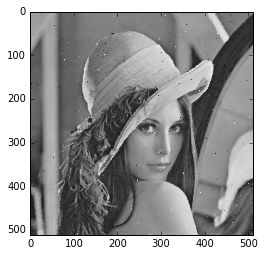

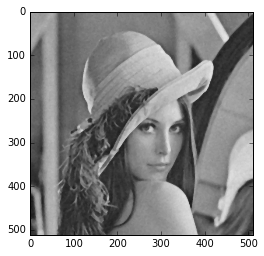

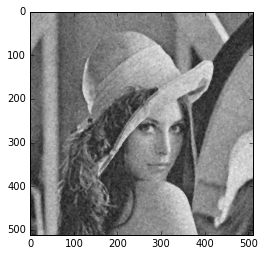

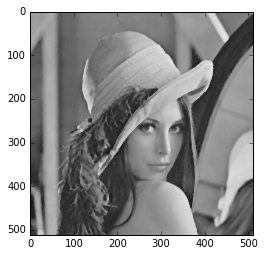

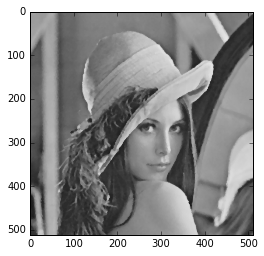

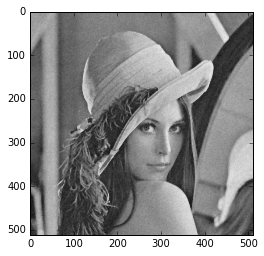

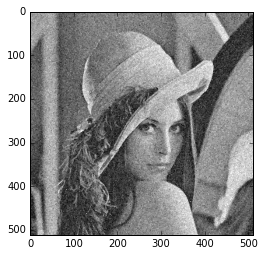

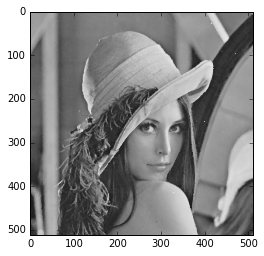

In [7]:
plt.figure(13)
median3x3_gaussian_10 = Image.fromarray(median_filter(guassian_10, (3, 3)), 'L')
median3x3_gaussian_10.save('median3x3_gaussian_10.bmp')
fig = plt.imshow(np.asarray(median3x3_gaussian_10), cmap='gray', vmin=0, vmax=255) #median3x3_gaussian_10
SNR_dict['median3x3_gaussian_10'] = SNR(img, median3x3_gaussian_10)
plt.figure(14)
median3x3_gaussian_30 = Image.fromarray(median_filter(guassian_30, (3, 3)), 'L')
median3x3_gaussian_30.save('median3x3_gaussian_30.bmp')
fig = plt.imshow(np.asarray(median3x3_gaussian_30), cmap='gray', vmin=0, vmax=255) #median3x3_gaussian_30
SNR_dict['median3x3_gaussian_30'] = SNR(img, median3x3_gaussian_30)
plt.figure(15)
median3x3_salt_005 = Image.fromarray(median_filter(salt_005, (3, 3)), 'L')
median3x3_salt_005.save('median3x3_salt_005.bmp')
fig = plt.imshow(np.asarray(median3x3_salt_005), cmap='gray', vmin=0, vmax=255) #median3x3_salt005
SNR_dict['median3x3_salt_005'] = SNR(img, median3x3_salt_005)
plt.figure(16)
median3x3_salt_01 = Image.fromarray(median_filter(salt_01, (3, 3)), 'L')
median3x3_salt_01.save('median3x3_salt_01.bmp')
fig = plt.imshow(np.asarray(median3x3_salt_01), cmap='gray', vmin=0, vmax=255) #median3x3_salt01
SNR_dict['median3x3_salt_01'] = SNR(img, median3x3_salt_01)
plt.figure(17)
median5x5_gaussian_10 = Image.fromarray(median_filter(guassian_10, (5, 5)), 'L')
median5x5_gaussian_10.save('median5x5_gaussian_10.bmp')
fig = plt.imshow(np.asarray(median5x5_gaussian_10), cmap='gray', vmin=0, vmax=255) #median5x5_gaussian_10
SNR_dict['median5x5_gaussian_10'] = SNR(img, median5x5_gaussian_10)
plt.figure(18)
median5x5_gaussian_30 = Image.fromarray(median_filter(guassian_30, (5, 5)), 'L')
median5x5_gaussian_30.save('median5x5_gaussian_30.bmp')
fig = plt.imshow(np.asarray(median5x5_gaussian_30), cmap='gray', vmin=0, vmax=255) #median5x5_gaussian_30
SNR_dict['median5x5_gaussian_30'] = SNR(img, median5x5_gaussian_30)
plt.figure(19)
median5x5_salt_005 = Image.fromarray(median_filter(salt_005, (5, 5)), 'L')
median5x5_salt_005.save('median5x5_salt_005.bmp')
fig = plt.imshow(np.asarray(median5x5_salt_005), cmap='gray', vmin=0, vmax=255) #median5x5_salt_005
SNR_dict['median5x5_salt_005'] = SNR(img, median5x5_salt_005)
plt.figure(20)
median5x5_salt_01 = Image.fromarray(median_filter(salt_01, (5, 5)), 'L')
median5x5_salt_01.save('median5x5_salt_01.bmp')
fig = plt.imshow(np.asarray(median5x5_salt_01), cmap='gray', vmin=0, vmax=255) #median5x5_salt_01
SNR_dict['median5x5_salt_01'] = SNR(img, median5x5_salt_01)

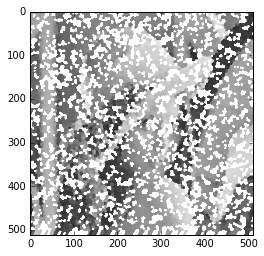

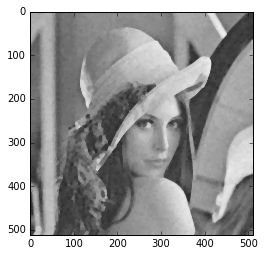

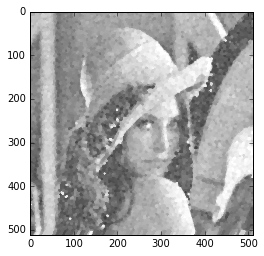

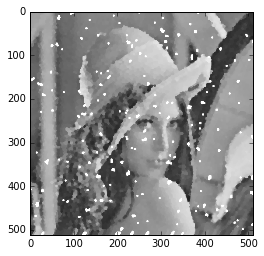

In [9]:
plt.figure(21)
closing_then_opening_guassian_10 = Image.fromarray(closing_then_opening(guassian_10, kernel), 'L')
closing_then_opening_guassian_10.save('closing_then_opening_guassian_10.bmp')
fig = plt.imshow(np.asarray(closing_then_opening_guassian_10), cmap='gray', vmin=0, vmax=255) #closing_then_opening_guassian_10
SNR_dict['closing_then_opening_guassian_10'] = SNR(img, closing_then_opening_guassian_10)
plt.figure(22)
closing_then_opening_guassian_30 = Image.fromarray(closing_then_opening(guassian_30, kernel), 'L')
closing_then_opening_guassian_30.save('closing_then_opening_guassian_30.bmp')
fig = plt.imshow(np.asarray(closing_then_opening_guassian_30), cmap='gray', vmin=0, vmax=255) #closing_then_opening_guassian_30
SNR_dict['closing_then_opening_guassian_30'] = SNR(img, closing_then_opening_guassian_30)
plt.figure(23)
closing_then_opening_salt_005 = Image.fromarray(closing_then_opening(salt_005, kernel), 'L')
closing_then_opening_salt_005.save('closing_then_opening_salt_005.bmp')
fig = plt.imshow(np.asarray(closing_then_opening_salt_005), cmap='gray', vmin=0, vmax=255) #closing_then_opening_salt_005
SNR_dict['closing_then_opening_salt_005'] = SNR(img, closing_then_opening_salt_005)
plt.figure(24)
closing_then_opening_salt_01 = Image.fromarray(closing_then_opening(salt_01, kernel), 'L')
closing_then_opening_salt_01.save('closing_then_opening_salt_01.bmp')
fig = plt.imshow(np.asarray(closing_then_opening_salt_01), cmap='gray', vmin=0, vmax=255) #closing_then_opening_salt_01
SNR_dict['closing_then_opening_salt_01'] = SNR(img, closing_then_opening_salt_01)

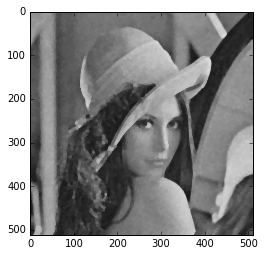

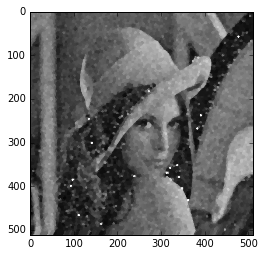

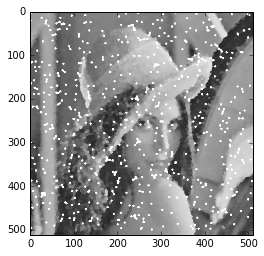

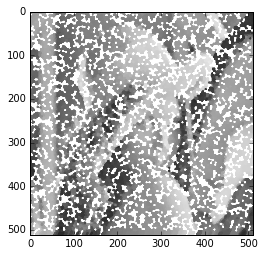

In [11]:
plt.figure(25)
opening_then_closing_guassian_10 = Image.fromarray(opening_then_closing(guassian_10, kernel), 'L')
opening_then_closing_guassian_10.save('opening_then_closing_guassian_10.bmp')
fig = plt.imshow(np.asarray(opening_then_closing_guassian_10), cmap='gray', vmin=0, vmax=255) #opening_then_closing_guassian_10
SNR_dict['opening_then_closing_guassian_10'] = SNR(img, opening_then_closing_guassian_10)
plt.figure(26)
opening_then_closing_guassian_30 = Image.fromarray(opening_then_closing(guassian_30, kernel), 'L')
opening_then_closing_guassian_30.save('opening_then_closing_guassian_30.bmp')
fig = plt.imshow(np.asarray(opening_then_closing_guassian_30), cmap='gray', vmin=0, vmax=255) #opening_then_closing_guassian_30
SNR_dict['opening_then_closing_guassian_30'] = SNR(img, opening_then_closing_guassian_30)
plt.figure(27)
opening_then_closing_salt_005 = Image.fromarray(opening_then_closing(salt_005, kernel), 'L')
opening_then_closing_salt_005.save('opening_then_closing_salt_005.bmp')
fig = plt.imshow(np.asarray(opening_then_closing_salt_005), cmap='gray', vmin=0, vmax=255) #opening_then_closing_salt_005
SNR_dict['opening_then_closing_salt_005'] = SNR(img, opening_then_closing_salt_005)
plt.figure(28)
opening_then_closing_salt_01 = Image.fromarray(opening_then_closing(salt_01, kernel), 'L')
opening_then_closing_salt_01.save('opening_then_closing_salt_01.bmp')
fig = plt.imshow(np.asarray(opening_then_closing_salt_01), cmap='gray', vmin=0, vmax=255) #opening_then_closing_salt_01
SNR_dict['opening_then_closing_salt_01'] = SNR(img, opening_then_closing_salt_01)

In [12]:
with open('SNR.json', 'w') as SNR_json:
    json.dump(SNR_dict, SNR_json)